In [1]:
import tensorflow as tf
import keras
from keras import layers
import os
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import soundfile as sf
import librosa

# import self-written function
from preprocess import MinMaxNormaliser

## The Variational Autoencoder Class

In [2]:
class Sampling(layers.Layer):
    """
    This layer is the bottleneck layer of a Variational Autoencoder (VAE). It uses the output from two dense layers 
    (mean and log_var) as input, converts them into a normal distribution and passes them to the decoder layer.

    The Sampling layer uses (mean, log_var) to sample z.
    """
 
    def call(self, inputs):
        """
        This method is called when the layer is invoked.

        Args:
            inputs (tuple): A tuple containing two elements - mean and log_var.

        Returns:
            z (tf.Tensor): The sampled vector encoding a digit.
        """
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = mean + tf.exp(0.5 * log_var) * epsilon
        return z
    


class VAE(keras.Model):
    """
    Variational Autoencoder (VAE) class. This class represents a VAE model, which is a type of generative model that 
    learns the underlying probability distribution of the input data. It can generate new data that is similar to the 
    input training data.
    """

    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides,
                 latent_space_dim, **kwargs):
        """
        Initialize the VAE model.

        Args:
            input_shape (tuple): Shape of the input data.
            conv_filters (list): List of the number of filters for each convolutional layer in the encoder.
            conv_kernels (list): List of the size of kernels for each convolutional layer in the encoder.
            conv_strides (list): List of the stride for each convolutional layer in the encoder.
            latent_space_dim (int): Dimensionality of the latent space.
            kwargs: Additional keyword arguments for the super class.
        """

        super().__init__(**kwargs)
        self.encoder_input_shape = input_shape 
        self.conv_filters = conv_filters 
        self.conv_kernels = conv_kernels 
        self.conv_strides = conv_strides 
        self.latent_space_dim = latent_space_dim 
        self.reconstruction_loss_weight = 1000000

        self.encoder = None
        self.decoder = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build_model()

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
 


    @property
    def metrics(self):
        """
        Return the metrics to be evaluated during training and testing.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
 


    def train_step(self, data):
        """
        Perform one training step.

        Args:
            data (tf.Tensor): Input data.

        Returns:
            dict: Dictionary of loss values to track.
        """
        with tf.GradientTape() as tape:
            mean,log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    


    def reconstruct(self, images):
        """
        Reconstruct the input images using the trained VAE model.

        Args:
            images (tf.Tensor): Input images.

        Returns:
            tuple: Tuple of reconstructed images and their corresponding latent vectors.
        """
        mean, log_var, z = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(z)
        return reconstructed_images, z
    


    def _build_model(self):
        """
        Build the VAE model. This includes building the encoder and decoder.
        """
        ## Build encoder
        self._model_input = keras.Input(shape=self.encoder_input_shape) 
        # add conv layers 
        x = self._model_input
        for layer_index in range(self._num_conv_layers):
            x = layers.Conv2D(filters=self.conv_filters[layer_index],
                                kernel_size=self.conv_kernels[layer_index],
                                activation="relu",
                                strides=self.conv_strides[layer_index],
                                padding="same")(x)
            x = layers.BatchNormalization()(x)
        # create bottleneck
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        mean = layers.Dense(self.latent_space_dim, name="mean")(x)
        log_var = layers.Dense(self.latent_space_dim, name="log_var")(x)
        z = Sampling()([mean, log_var])
        
        self.encoder = keras.Model(self._model_input, [mean, log_var, z], name="encoder")
        self.encoder.summary()

        ## Build decoder
        latent_inputs = keras.Input(shape=(self.latent_space_dim,))
        num_neurons = np.prod(self._shape_before_bottleneck)
        x = layers.Dense(num_neurons, activation="relu")(latent_inputs) 
        x = layers.Reshape(self._shape_before_bottleneck)(x) # use the shape of x before the bottleneck
        # add conv transpose layers
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = layers.Conv2DTranspose(filters=self.conv_filters[layer_index],
                                        kernel_size=self.conv_kernels[layer_index],
                                        activation="relu",
                                        strides=self.conv_strides[layer_index],
                                        padding="same")(x)
            x = layers.BatchNormalization()(x)
        decoder_outputs = layers.Conv2DTranspose(1, 
                                                kernel_size=self.conv_kernels[0],
                                                activation="sigmoid", 
                                                strides=self.conv_strides[0], 
                                                padding="same")(x)
        self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        self.decoder.summary()


    def save_parameters(self, save_path=os.path.join("model", "parameters.pkl")):
        """
        Save the parameters of the VAE model.

        Args:
            save_folder (str): The folder to save the parameters.
        """
        parameters = [
            self.encoder_input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    @classmethod
    def load_model(cls, parameters_path=os.path.join("model", "parameters.pkl"), weights_path=os.path.join("model", "trial_5.weights.h5")):
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        autoencoder.load_weights(weights_path)
        return autoencoder


## Load the preprocessed data

In [3]:
with open(os.path.join('dataset', 'fsdd', 'pickled_spectrograms.npy'), 'rb') as f:
    x_train = np.load(f)
print("Number of training samples: ", x_train.shape[0])

# Check whether the data contains corrupted samples
nan_count = np.count_nonzero(np.isnan(x_train))
print("Number of nan values in the data: ", nan_count)

Number of training samples:  289187
Number of nan values in the data:  0


# Build and train the model
(Training without a GPU will approximately take 6h for one epoch)

In [4]:
tf.config.run_functions_eagerly(True)

vae = VAE(
        input_shape=(256, 64, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )
vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
history = vae.fit(x_train, epochs=10, batch_size=32)

weights_path = os.path.join("model", "trial_0.weights.h5")
vae.save_weights(weights_path)
vae.save_parameters()

history_path = os.path.join("model", "history_0.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 32,   │      5,120 │ input_layer[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 32,   │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 16,    │  1,179,904 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 8,     │    295,040 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8,     │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 4, 64) │     73,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 4, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 4, 32)  │     18,464 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 4, 32)  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     16,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ mean[0][0],       │
│                     │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,597,040 (6.09 MB)

 Trainable params: 1,595,056 (6.08 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 4, 32)      │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 8, 64)      │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 16, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 32, 256)   │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 32, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 64, 1)     │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,089 (2.03 MB)

 Trainable params: 532,129 (2.03 MB)

 Non-trainable params: 960 (3.75 KB)

c:\Users\janas\anaconda3\envs\musicmodel\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9038/9038 ━━━━━━━━━━━━━━━━━━━━ 45843s 5s/step - kl_loss: 55.9411 - loss: 3802.0129 - reconstruction_loss: 3746.0557 - total_loss: 3629.8596


## Sound Generation
Load the trained model to generate sounds similar to the input

In [3]:
vae = VAE.load_model()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 32,   │      5,120 │ input_layer[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 32,   │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 16,    │  1,179,904 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 8,     │    295,040 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8,     │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 4, 64) │     73,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 4, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 4, 32)  │     18,464 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 4, 32)  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     16,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ mean[0][0],       │
│                     │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,597,040 (6.09 MB)

 Trainable params: 1,595,056 (6.08 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 4, 32)      │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 8, 64)      │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 16, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 32, 256)   │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 32, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 64, 1)     │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,089 (2.03 MB)

 Trainable params: 532,129 (2.03 MB)

 Non-trainable params: 960 (3.75 KB)

Load spectrograms, min max values and file_paths

In [5]:
with open(os.path.join('dataset', 'fsdd', 'min_max_values.pkl'), "rb") as f:
    min_max_values = pickle.load(f)

with open(os.path.join('dataset', 'fsdd', 'pickled_spectrograms.npy'), 'rb') as f:
    spectrograms = np.load(f)

with open(os.path.join('dataset', 'fsdd', 'pickled_filepaths.npy'), 'rb') as f:
    file_paths = np.load(f)


Select random spectrograms as input for the generation of similar sounds

In [6]:
def select_spectrograms(spectrograms, file_paths, min_max_values, num_new_spectrograms=5):
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_new_spectrograms)
    sampled_spectrograms = spectrograms[sampled_indexes]
    sampled_file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_labels = []
    for file_path in sampled_file_paths:
        label = os.path.split(file_path)[-1]
        label = label.split("_", 2) #2
        label = '_'.join(label[:2]) #2
        sampled_labels.append(label)
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                            sampled_file_paths]
    return sampled_spectrograms, sampled_min_max_values, sampled_labels

sampled_spectrograms, sampled_min_max_values, sampled_labels = select_spectrograms(spectrograms, file_paths, min_max_values)

Plot the first original spectrogram

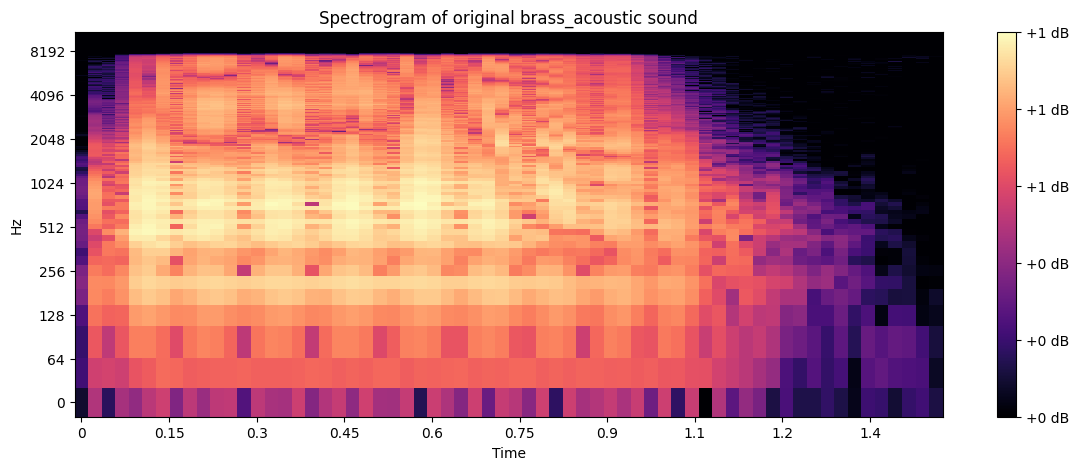

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(np.squeeze(sampled_spectrograms[0]), sr=22050, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(' '.join(['Spectrogram of original', sampled_labels[0], 'sound']))
# Save the plot
plt.savefig('original_spectrogram.png')
plt.show()

Generate new spectrograms based on the sampled input spectrograms

In [8]:
mean, log_var, z = vae.encoder.predict(sampled_spectrograms)
generated_spectrograms = vae.decoder.predict(z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Plot the first newly generated spectrogram

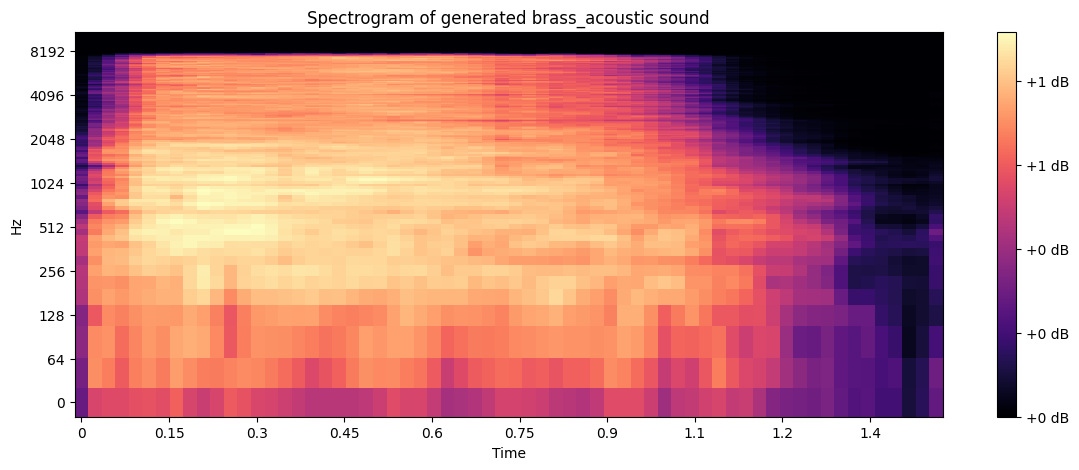

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(np.squeeze(generated_spectrograms[0]), sr=22050, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(' '.join(['Spectrogram of generated', sampled_labels[0], 'sound']))
# Save the plot
plt.savefig('generated_spectrogram.png')
plt.show()

Conversion of spectrograms to audio format and saving the audio data

In [10]:
def convert_spectograms_to_audio(spectograms, min_max_values, hop_length):
        signals = []
        for spectogram, min_max_value in zip(spectograms, min_max_values):
            # reshape the log spectogram
            log_spectogram = spectogram[:, :, 0] 

            # apply denormalization
            _min_max_normalizer = MinMaxNormaliser(0, 1)
            denorm_log_spec = _min_max_normalizer.denormalise(log_spectogram,
                                                                   min_max_value["min"],
                                                                   min_max_value["max"])

            # log spectogram -> spectogram
            spec = librosa.db_to_amplitude(denorm_log_spec)

            # apply Griffin-Lim
            signal = librosa.istft(spec, hop_length=hop_length)

            signals.append(signal)

        return signals

# Method to save the converted audio signals
def save_signals(signals, save_dir, sample_rate=22050):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

In [11]:
# Convert the newly generated spectrogram samples to audio files
generated_signals = convert_spectograms_to_audio(generated_spectrograms, sampled_min_max_values, hop_length=256)

# convert original spectrogram samples to audio
original_signals = convert_spectograms_to_audio(sampled_spectrograms, sampled_min_max_values, hop_length=256)

# save audio signals
save_signals(generated_signals, os.path.join('dataset', 'generation', 'original'))
save_signals(original_signals, os.path.join('dataset', 'generation', 'generated'))

Playing the original sound and the generated sound

In [12]:
# Play original audio
from IPython.display import Audio
Audio(original_signals[0], rate=22050)

In [13]:
# Play generated audio
from IPython.display import Audio
Audio(generated_signals[0], rate=22050)

Plotting the latent space

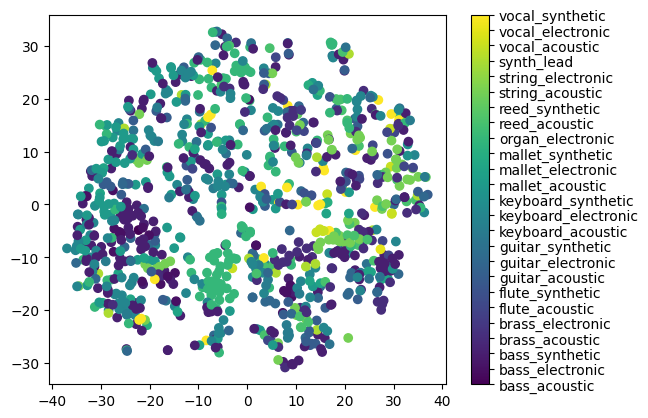

In [14]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

sampled_spectrograms, sampled_min_max_values, sampled_labels = select_spectrograms(spectrograms, file_paths, min_max_values, num_new_spectrograms=1000)

# Encode the data to the latent space
mean,log_var, z = vae.encoder(sampled_spectrograms)
mean = np.array(mean)

# Use t-SNE to reduce the dimensionality to 2
mean_2d = TSNE(n_components=2).fit_transform(mean)

# Transform the labels to numbers 
le = LabelEncoder()
number_labels = le.fit_transform(sampled_labels)
# Plot the 2D latent space
scatter = plt.scatter(mean_2d[:, 0], mean_2d[:, 1], c=number_labels)
# Create colorbar
cbar = plt.colorbar(scatter)

# Get the unique labels and their corresponding numbers
unique_labels = np.unique(sampled_labels)
unique_numbers = le.transform(unique_labels)

# Set the colorbar ticks and labels
cbar.set_ticks(unique_numbers)
cbar.set_ticklabels(unique_labels)
# Save the plot
plt.savefig('latent_space.png')
plt.show()
